# A2C on Hopper v4

In [1]:
import warnings
warnings.filterwarnings("ignore")
from torch import multiprocessing
from collections import defaultdict
import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter,
                          TransformedEnv)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import A2CLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

In [2]:
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)

## Setting parameters


In [3]:
num_cells = 256
lr = 3e-4
max_grad_norm = 1.0

frames_per_batch = 1000
total_frames = 250_000
#total_frames = 10_000

gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

## Environment setup

In [4]:
base_env = GymEnv("Hopper-v4", device=device)

env = TransformedEnv(
    base_env,
    Compose(
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(),
        StepCounter(),
    ),
)

env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)
check_env_specs(env)

2025-02-21 17:00:42,716 [torchrl][INFO] check_env_specs succeeded!


## Policy (Actor)


In [5]:
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

policy_module = TensorDictModule(actor_net, in_keys=["observation"], out_keys=["loc", "scale"])

policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "low": env.action_spec.space.low,
        "high": env.action_spec.space.high,
    },
    return_log_prob=True,
)

## Value network (Critic)


In [6]:
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(module=value_net, in_keys=["observation"])

In [7]:
# Initialize LazyLinear layers with a dummy input
dummy_input = env.reset()["observation"].unsqueeze(0)  # Create a dummy batch of observations

# Forward pass through actor and critic networks to initialize LazyLinear layers
with torch.no_grad():
    policy_module(dummy_input)  # Initialize actor
    value_module(dummy_input)   # Initialize critic

print("Actor and Critic networks initialized.")

Actor and Critic networks initialized.


## Data collector


In [8]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

# Replay buffer
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

## Loss function for A2C

In [9]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)
loss_module = A2CLoss(
    actor_network=policy_module,
    critic_network=value_module,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    critic_coef=1.0,
    loss_critic_type="smooth_l1",
)

## Training loop

In [10]:
optim = torch.optim.Adam(loss_module.parameters(), lr)
logs = defaultdict(list)
pbar = tqdm(total=total_frames)

for i, tensordict_data in enumerate(collector):
    advantage_module(tensordict_data)
    data_view = tensordict_data.reshape(-1)
    replay_buffer.extend(data_view.cpu())
    for _ in range(frames_per_batch // 64):
        subdata = replay_buffer.sample(64)
        loss_vals = loss_module(subdata.to(device))
        loss_value = loss_vals["loss_objective"] + loss_vals["loss_critic"] + loss_vals["loss_entropy"]
        
        loss_value.backward()
        torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
        optim.step()
        optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel())
    
    if i % 10 == 0:
        with set_exploration_type(ExplorationType.DETERMINISTIC), torch.no_grad():
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward (sum)"].append(eval_rollout["next", "reward"].sum().item())
        del eval_rollout

pbar.close()

100%|██████████| 250000/250000 [06:15<00:00, 666.35it/s]


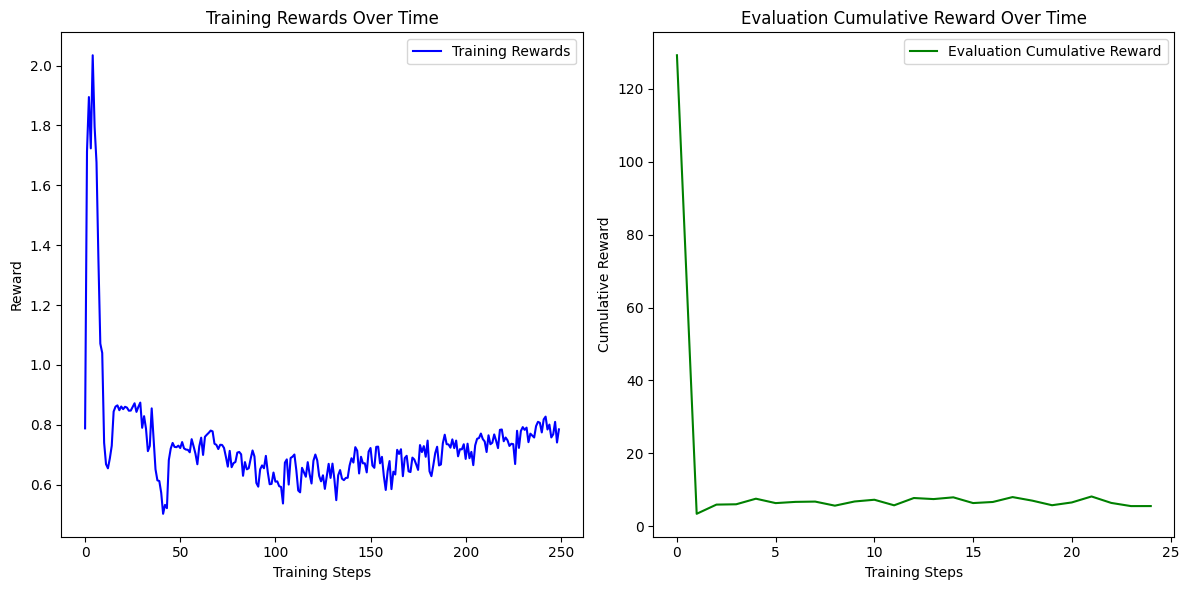

In [11]:
plt.figure(figsize=(12, 6))

# Plot Training Rewards
plt.subplot(1, 2, 1)
plt.plot(logs["reward"], label="Training Rewards", color='blue')
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.title("Training Rewards Over Time")
plt.legend()

# Plot Evaluation Cumulative Rewards
plt.subplot(1, 2, 2)
plt.plot(logs["eval reward (sum)"], label="Evaluation Cumulative Reward", color='green')
plt.xlabel("Training Steps")
plt.ylabel("Cumulative Reward")
plt.title("Evaluation Cumulative Reward Over Time")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


weird